In [24]:
include("../src/GeneticDemographicModel.jl")
include("../src/DomesticationModel.jl")
include("../src/DemographicParameters.jl")
include("../src/DomesticationParameters.jl")
include("../src/FecundityAgeRelationships.jl")

Main.FecundityAgeRelationships

In [25]:
Sa = DemographicParameters.Smyth_2016_survival
Fa = DemographicParameters.Smyth_16_F_vec
Wa = DemographicParameters.Smyth_16_WAR.(1:(length(Fa)+1))
R0 = 5.0
Rstar = 100.0
r = 0.0
Sd = (X,b) -> GeneticDemographicModel.BevertonHolt(X,b)
Vr = 0.5
# Scenario 1
targets = (S_F = 0.1, S_E = 0.05, S_J = 0.05, S_C = 0.025, rLRS = 0.85, 
           l50 = 40.0, theta = 10.0)
p_fixed = (a_r = 1.0,decreasing_selection = false,b_sa = 0.0,L_0 = 5.0,
            L_infty = 500,k = 0.05,b_Linfty=10.0,h2_lr=0.75, Vr = 0.5)
pars, natural_selection = DomesticationParameters.solve_parameters(targets,p_fixed)

s1 = 0.0*pars.s
s2 = 1.0*pars.s
s3 = 0.0*pars.s
rFaplastic = 0.6
popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
popH = DomesticationModel.init(Sa,Fa,pars)
print("selection strength", pars.s)

selection strength0.11774564227904767

In [26]:
using DataFrames, Plots
function init_df(t_init, t_hatchery, t_recovery)
    data = DataFrame()
    data.time = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.Recruitment = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.Fitness = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.mean = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.Fitness_H = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.mean_H = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.variance = 1:1.0:(t_init+t_hatchery+t_recovery)
    return data
end 

function statistics!(data,popW,popH,t)
    
    # calcualte statistics 
    Nt = popW.abundanceN[1]
    gradient = popW.gradient1.*popW.gradient2.*popW.gradient3
    Wt = sum(popW.traitN[:,1].*gradient)
    WHt = sum(popH.trait[:,1].*gradient)
    gbart = sum(popW.traitN[:,1].*popW.grid)
    gbarHt = sum(popH.trait[:,1].*popH.grid)
    Vt = sum(popW.traitN[:,1].*(popW.grid.-gbart).^2)
    
    data.time[t] = t
    data.Recruitment[t] = Nt
    data.Fitness[t] = Wt
    data.Fitness_H[t] = WHt
    data.mean[t] = gbart
    data.mean_H[t] = gbarHt
    data.variance[t] = Vt
    
    return Nt, Wt, gbart, Vt
end


function simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
    
    data = init_df(t_init, t_hatchery, t_recovery)

    for t in 1:t_init
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], 0.0)
        statistics!(data,popW,popH,t)
    end 
    
    for t in (t_init+1):(t_init+t_hatchery)
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], rH)
        DomesticationModel.time_step!(popH)
        statistics!(data,popW,popH,t)
    end 
    
    for t in (t_init+t_hatchery+1):(t_init+t_hatchery+t_recovery)
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], 0.0)
        statistics!(data,popW,popH,t)
    end 
    
    GeneticDemographicModel.rest!(popW)
    DomesticationModel.rest!(popH)
    
    return data
end


simulation (generic function with 1 method)

In [27]:
function minimum_values(data)
    W = data.Fitness./data.Fitness[1]
    Wmin = W[argmin(W)]
    N = data.Recruitment
    Nmin = N[argmin(N)]
    g = data.mean
    gmin = g[argmax(g)]
    return Wmin, Nmin,gmin 
end 


function heatmap_data(popW,popH,rH_range,t_hatchery_range; N = 10,t_init=10,t_recovery=200) 
    R = zeros(N,N)
    W = zeros(N,N)
    g = zeros(N,N)
    rH = rH_range[1]:((rH_range[end]-rH_range[1])/(N-1)):rH_range[end]
    t_hatchery = t_hatchery_range[1]:((t_hatchery_range[end]-t_hatchery_range[1])/(N-1)):t_hatchery_range[end]
    t_hatchery = broadcast(i -> round(Int,t_hatchery[i]), 1:length(t_hatchery))
    popHs = broadcast(i->deepcopy(popH),1:N) 
    popWs = broadcast(i->deepcopy(popW),1:N) 
    for i in 1:N
        Threads.@threads for j in 1:N
            print(i,j," ")
            data = simulation(popWs[j], popHs[j], rH[i], t_init, t_hatchery[j], t_recovery)
            Wij,Rij,gij=minimum_values(data)
            R[i,j] = Rij;W[i,j] = Wij;g[i,j] = gij
        end
    end 
    return R, W, g, rH, t_hatchery
end 

heatmap_data (generic function with 1 method)

In [28]:
rH_range = [0.0,100.0]
t_hatchery_range = [0.0,200.0]
R, W,g,rH, t_hatchery =heatmap_data(popW,popH,rH_range,t_hatchery_range; N = 30)


14 121 116 113 119 110 129 127 125 17 123 11 12 15 18 111 114 117 13 120 122 124 16 126 128 130 19 112 115 118 24 216 210 221 27 227 213 223 219 21 229 225 22 25 28 211 214 217 23 220 222 224 26 226 228 230 29 212 215 218 310 321 327 325 313 329 316 37 31 323 319 34 32 35 38 311 314 317 33 320 322 324 36 326 328 330 39 312 315 318 44 413 419 47 416 410 425 423 421 41 427 429 42 45 48 411 414 417 43 420 422 424 46 426 428 430 49 412 415 418 510 54 525 527 57 513 523 521 516 519 51 529 52 55 58 511 514 520 517 53 522 524 526 56 528 530 59 512 515 518 64 616 623 619 67 621 610 61 629 627 613 625 62 65 68 611 614 617 63 620 622 624 66 626 628 69 630 612 615 618 74 721 716 719 713 729 723 725 710 727 71 77 72 75 78 711 714 717 73 720 722 724 76 726 728 79 730 712 715 718 87 816 821 813 823 829 827 819 810 81 825 84 82 85 88 811 814 817 83 820 822 824 86 826 828 830 89 812 815 818 94 910 921 916 919 97 913 925 927 923 929 91 92 95 98 911 914 917 93 920 922 924 96 926 928 930 99 912 915 918 1

([99.97925438943611 99.97925438943611 … 99.97925438943611 99.97925438943611; 99.97925438943611 99.97925438943611 … 98.71041185913612 98.61944146172074; … ; 99.97925438943611 99.9344703558873 … 65.11344170911433 62.92885638986053; 99.97925438943611 99.93154051075732 … 64.24839348616398 62.02517685699931], [0.9999999999999998 0.9999999999999998 … 0.9999999999999998 0.9999999999999998; 0.9999999999999998 0.9999256594964187 … 0.990355222428567 0.9899743612754917; … ; 0.9999999999999998 0.9966654267607513 … 0.7510627778888739 0.7386927209866296; 0.9999999999999998 0.9965475671942758 … 0.7441163501802989 0.7313903578016531], [2.538481304360113e-7 2.5741174677688444e-7 … 3.385834677412703e-7 3.411814003127435e-7; 2.538481304360113e-7 0.0031817325691993956 … 0.14593069127996794 0.151447386026154; … ; 2.538481304360113e-7 0.08315493160365774 … 2.183048342094734 2.2591782563855127; 2.538481304360113e-7 0.08591354831010944 … 2.226765518285606 2.3045478304134845], 0.0:3.4482758620689653:100.0, [0,

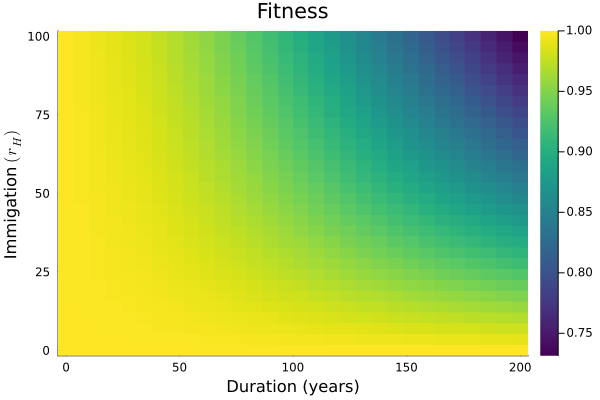

In [29]:
using LaTeXStrings
p1 = Plots.heatmap(t_hatchery,rH,W, xlabel = "Duration (years)", ylabel = string("Immigation ", L"(r_H)"),
                    title = "Fitness", c = :viridis)
p1

@save "data/fitness_matrix.jld" W

In [33]:
#@load "data/fitness_matrix.jld"
dWdrH = zeros(length(rH)-1, length(t_hatchery))
dWdT = zeros(length(rH), length(t_hatchery)-1)
    
for i in 2:length(rH)
    for j in 1:length(t_hatchery)
        dWdrH[i-1,j] = rH[end] * (W[i-1,j] - W[i,j])/(rH[i]-rH[i-1])
    end
end 


for i in 1:length(rH)
    for j in 2:length(t_hatchery)
        dWdT[i,j-1] = t_hatchery[end] * (W[i,j-1] - W[i,j])/(t_hatchery[j]-t_hatchery[j-1])
    end
end 

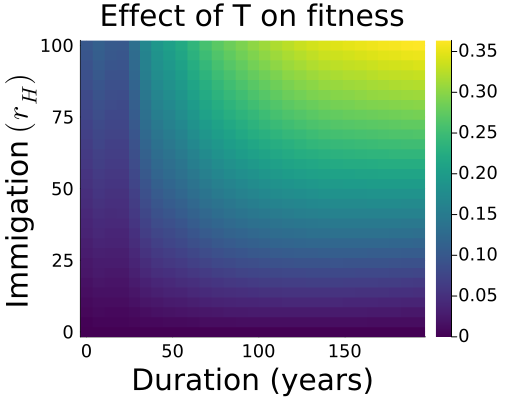

In [37]:
p1=Plots.heatmap(t_hatchery,rH[1:(end-1)],dWdrH, xlabel = "Duration (years)", ylabel = string("Immigation ", L"(r_H)"),
                    title = "Effect of rH on fitness", c = :viridis,
                    tickfontsize = 12, guidefontsize = 20, titlefontsize = 20)
plot(p1,size = (525,400),right_margin = 10mm)
savefig("figures/effectiveness_removals.png")

p2=Plots.heatmap(t_hatchery[1:(end-1)],rH,dWdT, xlabel = "Duration (years)",  ylabel = string("Immigation ", L"(r_H)"),
                title = "Effect of T on fitness", c = :viridis,
                tickfontsize = 12, guidefontsize = 20, titlefontsize = 20)
plot(p2,size = (525,400),right_margin = 10mm)
savefig("figures/effectiveness_duration.png")
plot(p2,size = (525,400),right_margin = 10mm)

In [5]:
function simulation(popW, popH, rH, removal_effort, removal_ages, t_init, t_hatchery, t_recovery)
    
    data = init_df(t_init, t_hatchery, t_recovery)

    for t in 1:t_init
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], 0.0)
        statistics!(data,popW,popH,t)
    end 
    
    total_removals = 0
    for t in (t_init+1):(t_init+t_hatchery)
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], rH)
        DomesticationModel.time_step!(popH)
        
        removals = (1 .-exp.(-1*removal_effort .* removal_ages)) .* popW.abundanceH
        
        popW.abundanceH .+= -1*removals 
        
        total_removals += sum(removals)
        statistics!(data,popW,popH,t)
    end 
    
    for t in (t_init+t_hatchery+1):(t_init+t_hatchery+t_recovery)
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], 0.0)
        removals = (1 .-exp.(-1*removal_effort .* removal_ages)) .* popW.abundanceH
        popW.abundanceH .+= -1*removals 
        total_removals += sum(removals)
        statistics!(data,popW,popH,t)
    end 
    
    GeneticDemographicModel.rest!(popW)
    DomesticationModel.rest!(popH)
    
    return total_removals, data
end


function removals_min_vals(popW, popH, rH, removal_effort, removal_ages, t_init, t_hatchery, t_recovery)
    total,data = simulation(popW, popH, rH, removal_effort, removal_ages, t_init, t_hatchery, t_recovery)
    W,N,g = minimum_values(data)
    return W, total
end

using Roots


function solve_removal_effort(popW, popH,rH,t_hatchery,removal_ages;t_init = 50,  t_recovery = 200)
    W0 = removals_min_vals(popW, popH, rH, 0.0, removal_ages, t_init, t_hatchery, t_recovery)[1]
    f = re -> removals_min_vals(popW, popH, rH, re, removal_ages, t_init, t_hatchery, t_recovery)[1]
    E = find_zero(re -> 0.5*(1-W0) .- (1-f(re)), [0.0,1.0])
    return E, removals_min_vals(popW, popH, rH, E, removal_ages, t_init, t_hatchery, t_recovery)[2]
end
    





solve_removal_effort (generic function with 1 method)

In [197]:
remove_juviniles = 1:popW.Amax .< 20
solve_removal_effort(popW, popH,50,50,remove_juviniles;t_init = 50,  t_recovery = 200)

(0.03792248519206898, 953.3691809644839)

In [185]:
remove_adults = 1:popW.Amax .> 20
solve_removal_effort(popW, popH,50,50,remove_adults;t_init = 50,  t_recovery = 200)

0.9823575116755863
0.008821244162206865
2.220446049250313e-16


(0.028999555233877268, 468.28287235127385)

In [36]:

function heatmap_removal_data(popW,popH,rH_range,t_hatchery_range, removal_ages; N = 10,t_init=2,t_recovery=100) 
    E = zeros(N,N)
    total = zeros(N,N)
    rH = rH_range[1]:((rH_range[end]-rH_range[1])/(N-1)):rH_range[end]
    t_hatchery = t_hatchery_range[1]:((t_hatchery_range[end]-t_hatchery_range[1])/(N-1)):t_hatchery_range[end]
    t_hatchery = broadcast(i -> round(Int,t_hatchery[i]), 1:length(t_hatchery))
    popHs = broadcast(i->deepcopy(popH),1:N) 
    popWs = broadcast(i->deepcopy(popW),1:N)
    for i in 1:N
        Threads.@threads for j in 1:N
            print(i,j," ")
            E_,total_ = solve_removal_effort(popWs[j], popHs[j],rH[i],t_hatchery[j],removal_ages;t_init = t_init,  t_recovery = t_recovery)
            E[i,j] = E_;total[i,j] = total_
        end
    end 
    return E,total, rH,t_hatchery 
end 

heatmap_removal_data (generic function with 1 method)

In [37]:
rH_range = [10.0,50.0]
t_hatchery_range = [10.0,200.0]
remove_juviniles = 1:popW.Amax .< 20
remove_adults = 1:popW.Amax .> 20
dat_juv = heatmap_removal_data(popW,popH,rH_range,t_hatchery_range, remove_juviniles; N = 3) 

11 13 12 22 23 21 32 33 31 

([0.032757988003825414 0.03621804576480864 0.035656525233609446; 0.03533977134448839 0.037537283519978086 0.03632826518722395; 0.03606273828941977 0.038855494531134724 0.037633150921086274], [34.204942763475316 387.1675573173983 728.9992566428888; 108.62882725799653 1192.3565744306013 2217.34305951221; 183.78221424621438 2037.5873781999003 3792.297698529618], 10.0:20.0:50.0, [10, 105, 200])

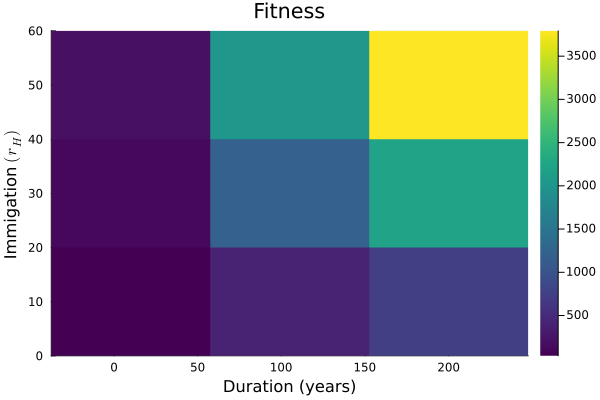

In [39]:
E,total, rH,t_hatchery  = dat_juv
Plots.heatmap(t_hatchery,rH,total, xlabel = "Duration (years)", ylabel = string("Immigation ", L"(r_H)"),
                    title = "Fitness", c = :viridis)

In [40]:
using JLD2
rH_range = [10.0,50.0]
t_hatchery_range = [10.0,200.0]
remove_juviniles = 1:popW.Amax .< 20
remove_adults = 1:popW.Amax .> 20
dat_juv = heatmap_removal_data(popW,popH,rH_range,t_hatchery_range, remove_juviniles; N = 20) 
@save "data/removal_juviniles.jld" dat_juv
dat_adults = heatmap_removal_data(popW,popH,rH_range,t_hatchery_range, remove_adults; N = 20) 
@save "data/removal_adults.jld" dat_adults

11 15 117 115 113 17 13 120 118 119 19 111 12 14 16 18 110 112 114 116 23 27 211 213 215 29 218 21 219 217 25 220 22 24 26 28 210 212 214 216 33 318 317 39 37 320 319 311 35 315 313 31 32 34 36 38 310 312 314 316 45 419 49 47 411 417 420 413 415 43 418 41 42 44 46 48 412 410 414 416 53 517 515 59 55 520 519 518 57 511 51 513 52 54 56 58 510 512 516 514 63 611 69 615 618 67 619 65 613 61 617 620 62 64 66 68 610 612 616 614 73 713 711 719 75 720 77 715 79 71 718 717 72 74 76 78 710 712 714 716 85 818 811 817 87 813 83 820 815 89 819 81 82 84 86 88 810 812 814 816 97 95 913 919 93 918 920 917 915 99 911 91 92 94 96 98 910 912 914 916 105 1013 107 1018 109 1019 103 101 1011 1020 1017 1015 102 104 106 108 1010 1012 1014 1016 113 117 1119 1118 1113 1115 1120 1117 119 111 115 1111 112 114 116 118 1112 1110 1114 1116 123 1215 129 1219 1211 1218 1217 127 125 1213 1220 121 122 124 126 128 1210 1212 1214 1216 1317 139 1311 135 1320 1313 1319 133 1315 137 1318 131 132 134 136 138 1310 1312 1314 13

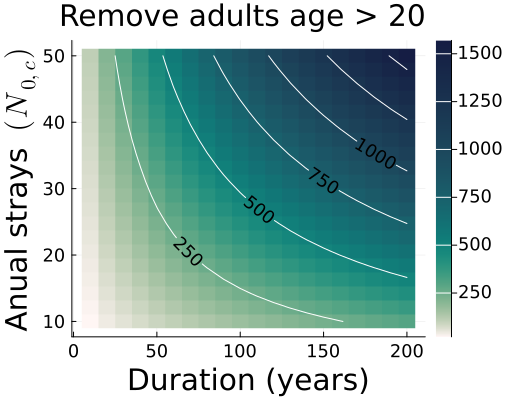

In [23]:
using LaTeXStrings
using JLD2
using Plots
using Plots.PlotMeasures
@load "data/removal_adults.jld"
E,Total,rH,T_ = dat_adults
cmin=Total[argmin(Total)]
cmax=Total[argmax(Total)]
inc = 250
p1 = Plots.heatmap(T_,rH,Total,c = cgrad(:tempo, scale =:exp))
Plots.contour!(T_,rH,Total, color = "white", levels = 0.0:250:1500,
contour_labels = true,xlabel=string("Duration (years)"), ylabel = string("Anual strays  ", L"(N_{0,c})"),
title = "Remove adults age > 20 ", contour_labels_color = "white", textcolor = "white")
Plots.plot!(T_,rH, alpha = 0.0,xtickfontcolor=:black,clabelfontcolor=:white,
            tickfontsize = 12, guidefontsize = 20, titlefontsize = 20, legend = false)

plot(p1,size = (525,400),right_margin = 10mm)
savefig("figures/total_removals_adults.png")

p2 = Plots.heatmap(T_,rH,Total,c = cgrad(:tempo, scale =:exp))
Plots.contour!(T_,rH,Total, color = "white", levels = 0.0:250:1500,
contour_labels = true,xlabel=string("Duration (years)"), ylabel = string("Anual strays  ", L"(N_{0,c})"),
title = "Remove adults age > 20 ", contour_labels_color = "white", textcolor = "black")
Plots.plot!(T_,rH, alpha = 0.0,xtickfontcolor=:black,clabelfontcolor=:white,
            tickfontsize = 12, guidefontsize = 20, titlefontsize = 20, legend = false)

plot(p2,size = (525,400),right_margin = 10mm)
savefig("figures/total_removals_adults_black_text.png")
plot(p2,size = (525,400),right_margin = 10mm)

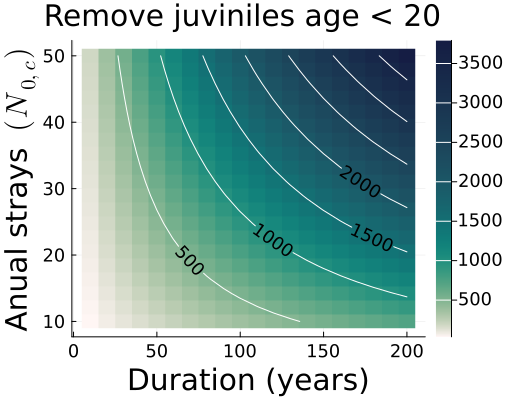

In [22]:
using LaTeXStrings
using JLD2
@load "data/removal_juviniles.jld"
E,Total,rH,T_ = dat_juv
cmin=Total[argmin(Total)]
cmax=Total[argmax(Total)]
inc = 250
p1=Plots.heatmap(T_,rH,Total,c = cgrad(:tempo, scale =:exp))
Plots.contour!(T_,rH,Total, color = "white", levels = 0.0:500:3500,
contour_labels = true,xlabel=string("Duration (years)"), ylabel = string("Anual strays  ", L"(N_{0,c})"),
title = "Remove juviniles age < 20 ", contour_labels_color = "white", textcolor = "white")
Plots.plot!(T_,rH, alpha = 0.0,xtickfontcolor=:black,clabelfontcolor=:white,
            tickfontsize = 12, guidefontsize = 20, titlefontsize = 20, legend = false)

plot(p1,size = (525,400),right_margin = 10mm)
savefig("figures/total_removals_juviniles.png")

p2=Plots.heatmap(T_,rH,Total,c = cgrad(:tempo, scale =:exp))
Plots.contour!(T_,rH,Total, color = "white", levels = 0.0:500:3500,
contour_labels = true,xlabel=string("Duration (years)"), ylabel = string("Anual strays  ", L"(N_{0,c})"),
title = "Remove juviniles age < 20 ", contour_labels_color = "white", textcolor = "black")
Plots.plot!(T_,rH, alpha = 0.0,xtickfontcolor=:black,clabelfontcolor=:white,
            tickfontsize = 12, guidefontsize = 20, titlefontsize = 20, legend = false)

plot(p2,size = (525,400),right_margin = 10mm)
savefig("figures/total_removals_juviniles_black_text.png")
plot(p2,size = (525,400),right_margin = 10mm)

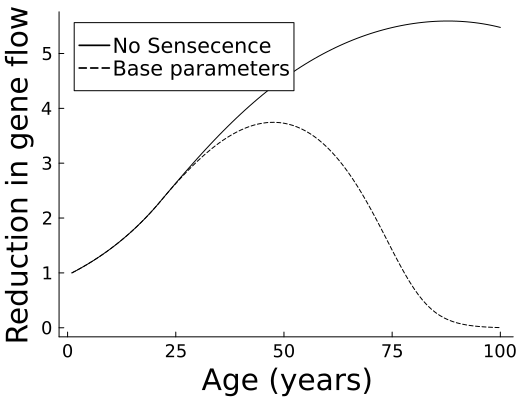

In [47]:
include("../src/DemographicParameters.jl")
Sa = DemographicParameters.Smyth_2016_survival
Fa = DemographicParameters.Smyth_16_F_vec
Amax = 150
EFEP(a::Int,Sa,Fa) = sum(broadcast(i->prod(Sa[a:i]),a:Amax) .*Fa[a:end] )
EFEP_dat = broadcast(a->EFEP(a,Sa,Fa),1:100)
p1=Plots.plot(1:100,EFEP_dat./EFEP_dat[1], color = "black", xlabel = "Age (years)",
ylabel = "Reduction in expected gene flow \n reletive to removal at age one", label ="No Sensecence", grid = false)


W100 = 9.3
Wmat = 153^3 *W100/(100^3)
K = 0.034
Linfty = 300
mu_s = 80  
sigma_s = 4 #0 #5
m = 0.04
Amax = 100
Fa = FecundityAgeRelationships.Walters2006Senescence(Linfty,Wmat,W100,K, 0, mu_s, sigma_s)
Fa = Fa.(1:Amax)
Sa = repeat([1-m],Amax) 

EFEP_dat = broadcast(a->EFEP(a,Sa,Fa),1:Amax)
Plots.plot!(p1,1:Amax,EFEP_dat./EFEP_dat[1], linestyle=:dash, color = "black", xlabel = "Age (years)",
                ylabel = "Reduction in gene flow",label ="Base parameters", grid = false,
                tickfontsize = 12, guidefontsize = 20, titlefontsize = 20, legendfontsize=14)
plot(p1,size = (525,400))
savefig("figures/removal_age.png")
plot(p1,size = (525,400))